# Initializations

In [2]:
import numpy as np
import pandas as pd

import json
from pprint import pprint

import sys, os, time
import glob

from matplotlib import pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from skimage.io import imread, imsave
from skimage.transform import resize

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.utils as vutils
import torch.optim as optim
import torchvision.utils as vutils

In [3]:
sys.path.append("/home/dhamodhar/ganum/citygan/citygan/model/")
import models_dcgan
from datafolder import basic_preprocess, default_loader, flip_ndimage

# Load experiment information

In [4]:
# experiment_dir = "/home//workspace/citygan/dcgan-0-res64-ngf128-ndf32-nz100/"
experiment_dir = "/home/dhamodhar/ganum/citygan/citygan/out_1L_256/"
# experiment_dir = "/home//workspace/citygan/dcgan-012-res256-ngf128-ndf32-dropoutGD-afterBN/"

with open(experiment_dir + "/params.json") as f:    
    config = json.load(f)
    
# Load last checkpointed generator model

# files_cptG = glob.glob(experiment_dir + "G*.pth")
files_cptG = glob.glob(experiment_dir + "*G*.pth")

files_cptG = {int(os.path.basename(f).split(".")[0].split("_")[-1]):f \
              for f in files_cptG}

netG_ckpt = files_cptG[(max(list(files_cptG.keys())))]
netD_ckpt = netG_ckpt.replace("netG", "netD")
print (netG_ckpt)
print (netD_ckpt)

config

/home/dhamodhar/ganum/citygan/citygan/out_1L_256/netG_epoch_900.pth
/home/dhamodhar/ganum/citygan/citygan/out_1L_256/netD_epoch_900.pth


{'batchSize': 64,
 'beta1': 0.5,
 'cuda': True,
 'custom_loader': False,
 'dataroot': '/home/dhamodhar/ganum/citygan/citygan/above_2k',
 'dataset': 'spatial-maps',
 'fix_dynamic_range': False,
 'flips': False,
 'gpu_ids': [0],
 'imageSize': 256,
 'lr': 0.0002,
 'lr_halve': 100,
 'manualSeed': 6505,
 'nc': 1,
 'ndf': 32,
 'netD': '',
 'netG': '',
 'ngf': 128,
 'niter': 1000,
 'normalize': False,
 'nz': 200,
 'outf': '/home/dhamodhar/ganum/citygan/citygan/out_1k_256',
 'rotate_angle': 0,
 'take_log': False,
 'use_channels': [0, 1, 2],
 'workers': 4}

In [5]:
# Load DCGAN model

z_num = config['nz']
width = config['imageSize']
channel_names = ['bldg', 'pop', 'lum']
nc = config['nc']
gpu_ids = [0]# ,1,2,3]
repeat_num = int(np.log2(width)) - 3

netG = models_dcgan.GeneratorCNN(z_num, config['ngf'], config['nc'], 
                                 repeat_num, gpu_ids, dropout=0)
netG.load_state_dict(torch.load(netG_ckpt))

if torch.cuda.is_available() and len(gpu_ids)>0:
    netG = netG.cuda()
    
netG

GeneratorCNN(
  (main): Sequential(
    (0): ConvTranspose2d(200, 4096, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(4096, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1

#### Generate synthetic samples

In [6]:
def generate_samples(netG, Z, cuda=False):
    N, nz = Z.shape[:2]
    Zv = torch.FloatTensor(Z.reshape(N, nz,1,1))
    if cuda:
        Zv = Zv.cuda()
    Zv = Variable(Zv)
    fake = netG(Zv)
    return fake

In [7]:
from tqdm import tqdm

In [8]:
for i in tqdm(range(300)):
    Z = np.random.randn(1, z_num)
    x_fake = generate_samples(netG, Z.reshape((1,z_num,1,1)), cuda=True)
    vutils.save_image(x_fake.data,"../generated_images/1L_synthetic_images/sample_" + str(i) + ".tif") 

100%|██████████| 300/300 [00:05<00:00, 52.11it/s] 


In [8]:
N = 24
Z = np.random.randn(N, z_num)
x_fake = generate_samples(netG, Z.reshape((N,z_num,1,1)), cuda=True)
vutils.save_image(x_fake.data,"random_synthetic_samples.png")

##### Compare synthetic samples to real samples

In [8]:
def frame_image(img, frame_width):
    b = frame_width # border size in pixel
    ny, nx = img.shape[0], img.shape[1] # resolution / number of pixels in x and y
    if img.ndim == 3: # rgb or rgba array
        framed_img = np.ones((b+ny+b, b+nx+b, img.shape[2]))
    elif img.ndim == 2: # grayscale image
        framed_img = np.ones((b+ny+b, b+nx+b))
    framed_img[b:-b, b:-b] = img
    return framed_img

def format_pop(pop):
    if pop > 1e6:
        div = 1e6
        s = 'M'
    else:
        div = 1e3
        s = 'k'
    return "%2.1f%s"%(float(pop)/div, s)

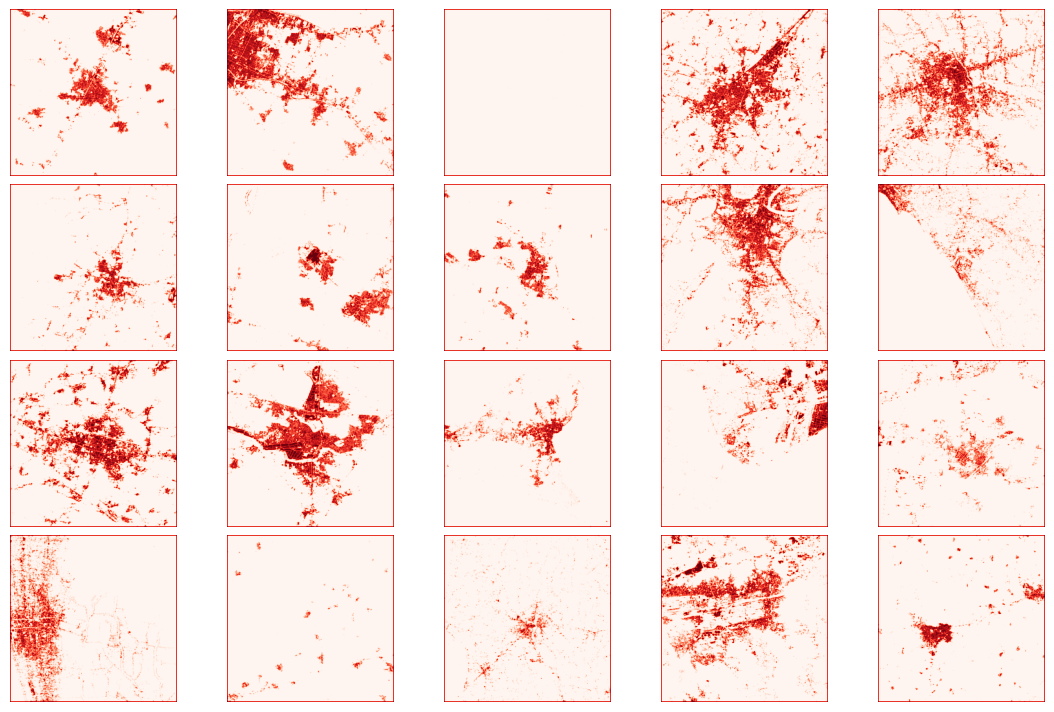

In [12]:
# plot real samples
N = 20

files = np.array(glob.glob(config['dataroot'] + "/*/*.tif"))
width = config['imageSize']
files = files[np.random.randint(0, len(files), N)]
img_list = [resize(imread(f), (width,width)) for f in files]
img_list = np.array(img_list)
img_list = img_list.reshape((N*1,1,width,width), order='C')

img_list.shape
# sns.reset_defaults()
fig, ax = plt.subplots(nrows=4, ncols=int(N/4), figsize=(14,9), 
                       gridspec_kw={"wspace":0.0, "hspace":0.05})

for img, f, a in zip(img_list, files, ax.flatten()):
    a.imshow(frame_image(img[0],1), cmap=cm.Reds)
    _ = a.axis("off")
    
fig.savefig('../figures/example_real_cities.png', bbox_inches='tight')

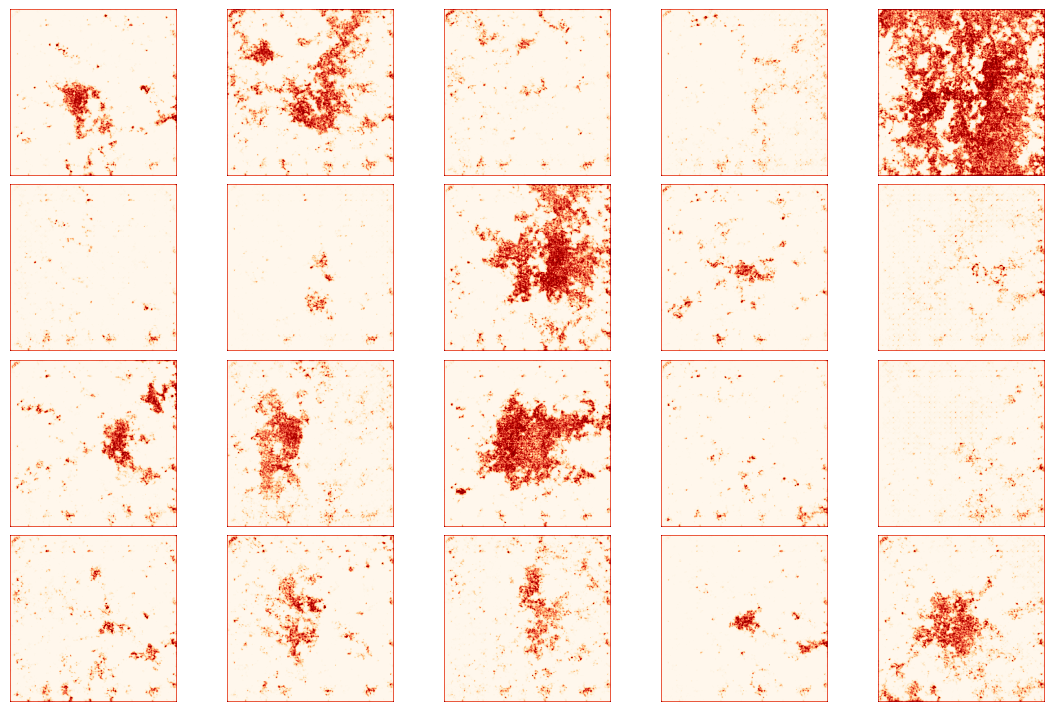

In [19]:
# plot fake examples
N = 20
Z = np.random.randn(N, z_num)
img_fake = generate_samples(netG, Z.reshape((N,z_num,1,1)), cuda=True)\
            .cpu().data.numpy()

fig, ax = plt.subplots(nrows=4, ncols=int(N/4), figsize=(14,9), 
                       gridspec_kw={"wspace":0.0, "hspace":0.05})
for i, a in enumerate(ax.flatten()):
    img = img_fake[i][0]
    img = (img - img.min()) / (img.max()-img.min())
    a.imshow(frame_image(img,1), cmap=cm.OrRd)
    _ = a.axis("off")
    
fig.savefig('../figures/example_fake_cities.png', bbox_inches='tight')


# Compare radial average profiles for real vs fake

Generate many synthetic cities, compare stats with those of real cities.

In [13]:
colormap = {"bldg":"black", "pop":"green", "lum":"orange", 
            "all":"blue", "bnds":"gray"}

def get_profiles(city_info):
    prof = {}
    for s in ['bldg', 'pop', 'lum', 'bnds']:
        mu = city_info['profiles'][s][0][2:]
        scale = mu.max() #v['sum area'][s]
        p = mu / scale
        p[np.isnan(p)] = 0
        prof[s] = p
    return prof

def plot_profiles(city_info, a, title=None):
    prof = get_profiles(city_info)
    for s in ['bldg', 'pop', 'lum', 'bnds']:
        a.plot(distance_km[2:], prof[s], lw=3, label=s, color=colormap[s])
     # a.legend(loc="best")
    if title is not None:
        a.set_title(title)
        

##### Load stats for real cities

In [14]:
import sys
sys.path.append("../urbanization-patterns/cityanalysis")
from cityanalysis import City
from cityanalysis import fractal_dimension

def compute_profiles(img0, mask, bnds, sample_name, step=1.0):
    img = img0.copy()
    city = City(img, mask=mask, bounds=bnds, name=sample_name, 
                sources=["bldg", "pop", "lum"])
    try:
        city.analyze(step=step)
        city.analyze(step=step, within_bounds=True)
    except:
        return None
    stats = {"profiles":{k:(np.nan_to_num(v[0]), np.nan_to_num(v[1]))\
                         for k,v in city.profiles.items()}, 
             "profiles bnds":{k:(np.nan_to_num(v[0]), np.nan_to_num(v[1]))\
                         for k,v in city.profiles_bnds.items()}, 
             "frac dim":city.fractal_dim, 
             "frac dim bnds":city.fractal_dim_bnds, 
             "avg area":city.avg_areas, 
             "sum area":city.sum_areas, 
             "avg area bnds":city.avg_areas_bnds, 
             "sum area bnds":city.sum_areas_bnds, 
             "area dis":city.areas_distr,
             "area dis bnds":city.areas_distr_bnds,
            }
    return stats

In [15]:
# load pre-computed profile data
import gzip 
import pickle
from shapely.geometry import shape
from shapely.wkt import loads


# normalize profiles by the scale
width = 256
mask = np.ones((width, width))
bnds = np.ones((width, width))

files = np.array(glob.glob(config['dataroot'] + "/*/*.tif"))
l2w = [imread(f) for f in files]
for i in tqdm(range(len(l2w))):
    if(l2w[i].shape[1] == 1113):
        l2w[i]  = np.delete(l2w[i],-1,1)
    l2w[i] = resize(l2w[i],(width,width,1))

cities_real = []
for i in tqdm(range(len(l2w))):
    img = l2w[i]
    img = basic_preprocess(img, width, normalize=True)
    s = compute_profiles(img, mask, bnds, "", step=0.501)
    cities_real += [s]       


L = len(cities_real[0]['profiles']['bldg'][0]) # length of profile in km
distance_km = np.arange(L)

Xbld = np.vstack([v['profiles']['bldg'][0] for v in cities_real])

Xbld_hat = Xbld / Xbld.max(1)[:,None]
Xbld_hat[np.isnan(Xbld_hat)] = 0

# convert to logarithmic space

Xbld_hat_log = np.log10(Xbld_hat)
Xbld_hat_log[np.isnan(Xbld_hat_log)] = 0
Xbld_hat_log[np.isneginf(Xbld_hat_log) | np.isinf(Xbld_hat_log)] = 0

100%|██████████| 504/504 [34:51<00:00,  4.15s/it]


##### Generate many synthetic cities, compute radial profiles

In [51]:
N = 1000
n = 100

cities_fake = []
mask = np.ones((width, width))
bnds = np.ones((width, width))
for b in tqdm(np.arange(0, N/n)):
    clear_output(wait=True)
    print (b, "/", N/n)
    # generate fake cities batch
    Z = np.random.randn(n, z_num)
    x_fake = generate_samples(netG, Z.reshape((n,z_num,1,1)), cuda=True)
    img_fake = x_fake.data.cpu().numpy().transpose((0,2,3,1))
    # compute stats
    for i in range(n):
        img = img_fake[i]
        img = basic_preprocess(img, width, normalize=True)
        s = compute_profiles(img, mask, bnds, "", step=0.501)
        cities_fake += [s]       


Xbld_fake = np.vstack([v['profiles']['bldg'][0] for v in cities_fake])
Xbld_fake[np.isnan(Xbld_fake)] = 0

Xbld_fake_hat = Xbld_fake / Xbld_fake.max(1)[:,None]
Xbld[np.isnan(Xbld)] = 0

# normalize profiles by the scale

Xbld_hat_fake = Xbld_fake / Xbld_fake.max(1)[:,None]
Xbld_hat_fake[np.isnan(Xbld_hat_fake)] = 0

# convert to logarithmic space

Xbld_hat_fake_log = np.log10(Xbld_hat_fake)
Xbld_hat_fake_log[np.isnan(Xbld_hat_fake_log)] = 0
Xbld_hat_fake_log[np.isneginf(Xbld_hat_fake_log) | np.isinf(Xbld_hat_fake_log)] = 0

9.0 / 10.0


100%|██████████| 10/10 [1:03:12<00:00, 379.20s/it]


In [12]:
# N = 3000
# n = 100
# cities_fake = []
# for b in np.arange(0, N/n):
#     clear_output(wait=True)
#     print (b, "/", N/n)
#     # generate fake cities batch
#     Z = np.random.randn(n, z_num)
#     x_fake = generate_samples(netG, Z.reshape((n,z_num,1,1)), cuda=True)
#     img_fake = x_fake.data.cpu().numpy().transpose((0,2,3,1))
#     for i in range(n):
#         img = img_fake[i][:,:,0]
#         # print(img[:,:,0].shape)
#         # plt.imshow(img,cmap='gray')
#         # plt.show()
#         # break
#         img = basic_preprocess(img, width, normalize=True)
#         # s = compute_profiles(img, mask, bnds, "", step=0.67)
#         cities_fake.append(img)
#     # break

# Xbld_fake = np.vstack(cities_fake)
# Xbld_fake[np.isnan(Xbld_fake)] = 0

# Xbld_fake_hat = Xbld_fake / Xbld_fake.max(1)[:,None]
# Xbld[np.isnan(Xbld)] = 0

# # normalize profiles by the scale

# Xbld_hat_fake = Xbld_fake / Xbld_fake.max(1)[:,None]
# Xbld_hat_fake[np.isnan(Xbld_hat_fake)] = 0

# # convert to logarithmic space

# Xbld_hat_fake_log = np.log10(Xbld_hat_fake)
# Xbld_hat_fake_log[np.isnan(Xbld_hat_fake_log)] = 0
# Xbld_hat_fake_log[np.isneginf(Xbld_hat_fake_log) | np.isinf(Xbld_hat_fake_log)] = 0

29.0 / 30.0


In [52]:
Xbld_hat_fake_log.shape

(1000, 256)

# Compare avg. radial gradient: real vs fake

In [53]:
from scipy.stats import linregress
distance_km = np.arange(width)
def f_ols(y):
    g, c, R, p, s = linregress(distance_km,y)
    return g, c, R**2, p, s

def ecdf(arr):
    hist, bins = np.histogram(arr,bins=100)
    hist = hist / float(len(arr))
    return bins[:-1], np.cumsum(hist)

In [54]:
distance_km.shape

(256,)

In [55]:
# average radial gradient: real cities
grad_bld = map(f_ols, Xbld_hat_log)
grad_bld = pd.DataFrame(grad_bld, 
                        columns=["slope", "intercept", "rvalue", "pvalue", "stderr"])
# grad_bld = pd.concat([info_df, grad_bld], axis=1)
grad_bld['slope'][grad_bld['pvalue']>0.05] = 0

print('1st part done')
# average radial gradient: fake cities
grad_bld_fake = map(f_ols, Xbld_hat_fake_log)
grad_bld_fake = pd.DataFrame(grad_bld_fake, 
                        columns=["slope", "intercept", "rvalue", "pvalue", "stderr"])
grad_bld_fake['slope'][grad_bld_fake['pvalue']>0.05] = 0

1st part done


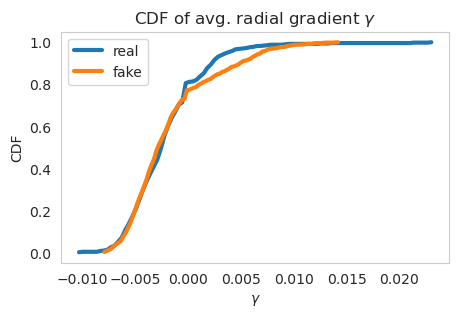

In [19]:
p = -0.08
q = 0.03

gamma_real = grad_bld['slope'][(grad_bld['slope']>p) & (grad_bld['slope']<q)]
bins_real, gamma_cdf_real = ecdf(gamma_real)

gamma_fake = grad_bld_fake['slope'][(grad_bld_fake['slope']>p) & (grad_bld_fake['slope']<q)]
bins_fake, gamma_cdf_fake = ecdf(gamma_fake)

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(bins_real, gamma_cdf_real, label="real", lw=3)
ax.plot(bins_fake, gamma_cdf_fake, label="fake", lw=3)
ax.legend(loc="best")
ax.set_title("CDF of avg. radial gradient $\gamma$")
ax.set_xlabel("$\gamma$")
ax.set_ylabel("CDF")

fig.savefig('../figures/CDF_gamma_real_vs_fake.pdf', 
            format='pdf', dpi=1200, bbox_inches='tight')


Text(0, 0.5, 'CDF')

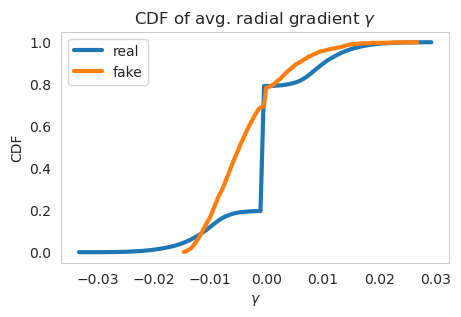

In [63]:
p = -0.08
q = 0.03

gamma_real = grad_bld['slope'][(grad_bld['slope']>p) & (grad_bld['slope']<q)]
bins_real, gamma_cdf_real = ecdf(gamma_real)

gamma_fake = grad_bld_fake['slope'][(grad_bld_fake['slope']>p) & (grad_bld_fake['slope']<q)]
bins_fake, gamma_cdf_fake = ecdf(gamma_fake)

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(bins_real, gamma_cdf_real, label="real", lw=3)
ax.plot(bins_fake, gamma_cdf_fake, label="fake", lw=3)
ax.legend(loc="best")
ax.set_title("CDF of avg. radial gradient $\gamma$")
ax.set_xlabel("$\gamma$")
ax.set_ylabel("CDF")

# fig.savefig('../figures/CDF_gamma_real_vs_fake.pdf', 
#             format='pdf', dpi=1200, bbox_inches='tight')


# Compare # peaks for real vs fake

In [16]:
import peakutils

def find_peaks(x, theta=0.15, xi=4):
    if x.sum()>0:
        idx = peakutils.indexes(x, thres=theta, min_dist=xi)
        return idx
    else:
        return []

def find_nr_peaks(X, theta=0.15, xi=4):
    idx_peaks = map(lambda x: find_peaks(x, theta=theta, xi=xi),X)
    return map(lambda x: len(x), idx_peaks)    

In [17]:
from skimage.transform import resize
from skimage.io import imread, imsave

def read_img(f, imgSize=None, scale=False, thresh=0):
    img = imread(f)
    img[img<thresh] = 0
    if imgSize is not None:
        img = resize(img, (imgSize, imgSize), preserve_range=True)
    if scale:
        img = (img - img.min()) / float((img.max() - img.min()))
    return img

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


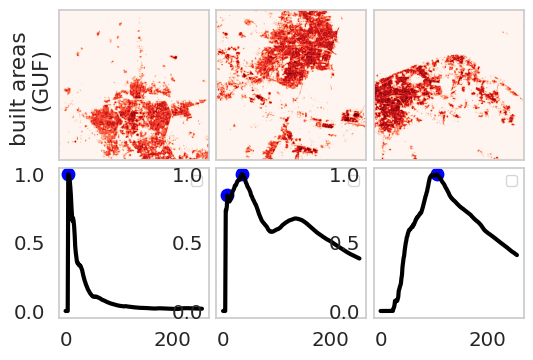

In [18]:
import matplotlib.gridspec as gridspec

# samples_path = "/home/data/world-cities/spatial-maps/samples"

sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 1})
fig, ax = plt.subplots(2,3, figsize=(6,4), 
                       gridspec_kw={"wspace":0.05, "hspace":0.05})

# for i,(cityname,(v,sample_name)) in enumerate(cities_smpl.iteritems()):
# filename = "%s/%s.tif" % (samples_path, sample_name)
# city_pop = v['population']
filename = config['dataroot'] + '/dir/G14.tif'
img = read_img(filename)
img = resize(img,(width,width))
ax0 = ax[0,0]; ax0.set_xticks([]); ax0.set_yticks([])
ax0.imshow(img, cm.Reds); ax0.set_ylabel("built areas \n (GUF)")

filename = config['dataroot'] + '/dir/G12.tif'
img2 = read_img(filename)
img2 = resize(img2,(width,width))
ax0 = ax[0,1]; ax0.set_xticks([]); ax0.set_yticks([])
ax0.imshow(img2, cm.Reds); 

filename = config['dataroot'] + '/dir/G15.tif'
img3 = read_img(filename)
img3 = resize(img3,(width,width))
ax0 = ax[0,2]; ax0.set_xticks([]); ax0.set_yticks([])
ax0.imshow(img3, cm.Reds); 


i = 0

img_temp = imread(config['dataroot']+"/dir/G14.tif")
img_temp = resize(img_temp,(width,width,1))
img_temp = basic_preprocess(img_temp, width, normalize=True)
s = compute_profiles(img_temp, mask, bnds, "", step=0.501)
# plot profiles
ax1 = ax[1,0]; 
if i > 0:
    ax1.set_yticks([])
mu = s['profiles']['bldg'][0]
scale = mu.max() #v['sum area'][s]
x_hat = mu / scale
idx_peaks = find_peaks(x_hat, theta=0.8, xi=10)
ax1.plot(distance_km, x_hat, lw=3, color="black")
ax1.scatter(idx_peaks, x_hat[idx_peaks],
          color='blue', marker="o", s=80)
ax1.legend(loc="best", fontsize=10)

img_temp = imread(config['dataroot']+"/dir/G12.tif")
img_temp = resize(img_temp,(width,width,1))
img_temp = basic_preprocess(img_temp, width, normalize=True)
s = compute_profiles(img_temp, mask, bnds, "", step=0.501)
img_temp
ax1 = ax[1,1]
mu = s['profiles']['bldg'][0]
scale = mu.max() #v['sum area'][s]
x_hat = mu / scale
idx_peaks = find_peaks(x_hat, theta=0.8, xi=10)
ax1.plot(distance_km, x_hat, lw=3, color="black")
ax1.scatter(idx_peaks, x_hat[idx_peaks],
          color='blue', marker="o", s=80)
ax1.legend(loc="best", fontsize=10)

img_temp = imread(config['dataroot']+"/dir/G15.tif")
img_temp = resize(img_temp,(width,width,1))
img_temp = basic_preprocess(img_temp, width, normalize=True)
s = compute_profiles(img_temp, mask, bnds, "", step=0.501)
ax1 = ax[1,2]
mu = s['profiles']['bldg'][0]
scale = mu.max() #v['sum area'][s]
x_hat = mu / scale
idx_peaks = find_peaks(x_hat, theta=0.8, xi=10)
ax1.plot(distance_km, x_hat, lw=3, color="black")
ax1.scatter(idx_peaks, x_hat[idx_peaks],
          color='blue', marker="o", s=80)
ax1.legend(loc="best", fontsize=10)

fig.savefig('../figures/example_profiles_peaks.png', bbox_inches='tight')


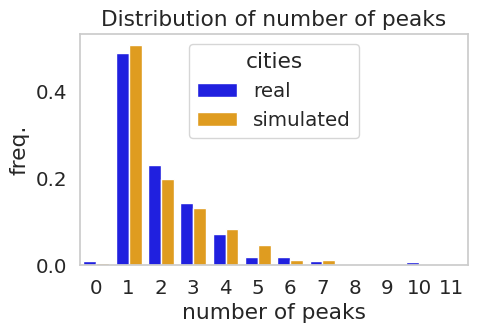

In [42]:
peaks_bld_real = find_nr_peaks(Xbld_hat, theta=0.8, xi=10)
peaks_bld_fake = find_nr_peaks(Xbld_hat_fake, theta=0.8, xi=10)
# print('0')
peaks_bld_real_list  = list(peaks_bld_real)
peaks_bld_fake_list  = list(peaks_bld_fake)

peaks_df = pd.DataFrame(peaks_bld_real_list + peaks_bld_fake_list, columns=["peaks"])
peaks_df['cities'] = 'simulated'
peaks_df['cities'][:len(list(peaks_bld_real_list))] = 'real'

peaks_freq = peaks_df.groupby("cities").apply(lambda x: x['peaks'].value_counts()/float(len(x)))
peaks_freq = pd.DataFrame(peaks_freq.reset_index())

peaks_freq.columns = ["cities", "peaks", "freq"]

fig, ax = plt.subplots(figsize=(5,3))
sns.barplot(ax=ax, data=peaks_freq, 
              x="peaks", y="freq", hue="cities", palette=["blue", "orange"])
ax.set_xlabel("number of peaks")
ax.set_ylabel("freq.")
ax.set_title("Distribution of number of peaks")
# print('4')
fig.savefig('../figures/peaks_real_vs_fake.png', bbox_inches='tight')

In [66]:
fig.savefig('../figures/peaks_real_vs_fake.pdf', 
            format='pdf', dpi=1200, bbox_inches='tight')

In [32]:
from scipy.stats import chisquare
freq_peak_real = pd.Series(peaks_bld_real).value_counts()/float(len(list(peaks_bld_real)))
freq_peak_real = freq_peak_real.sort_index()
freq_peak_fake = pd.Series(peaks_bld_fake).value_counts()/float(len(list(peaks_bld_fake)))
freq_peak_fake = freq_peak_fake.sort_index()

chisq = chisquare([0.1,0.6, 0.3], [0.1,0.6, 0.3], ddof=0)
print (chisq.pvalue, chisq.statistic)

chisq = chisquare(freq_peak_fake.values, freq_peak_real.values, ddof=0)
print (1-chisq.pvalue, chisq.statistic)

1.0 0.0


ValueError: shapes (19,) and (18,) could not be broadcast together

In [396]:
np.vstack([freq_peak_fake, freq_peak_real]).round(3)

array([[ 0.039,  0.599,  0.25 ,  0.085,  0.024,  0.004,  0.   ],
       [ 0.097,  0.537,  0.241,  0.09 ,  0.028,  0.006,  0.   ]])

# Compare radial profile clusters real vs fake

##### Extract profile clusters

In [56]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from numpy.random import random_sample
from scipy.spatial.distance import cdist, pdist

def kmeans_var_expl(data, n):
    kMeansVar = [MiniBatchKMeans(n_clusters=k, batch_size=1000).fit(data) for k in range(1, n)]
    centroids = [X.cluster_centers_ for X in kMeansVar]
    k_euclid = [cdist(data, cent) for cent in centroids]
    dist = [np.min(ke, axis=1) for ke in k_euclid]
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss - wcss
    return tss, bss, wcss

In [57]:
Xbld_hat_fake.shape

(1000, 256)

In [58]:
X_real = Xbld_hat
X_fake = Xbld_hat_fake

# real cities
tss, bss, wcss = kmeans_var_expl(X_real, 50)
var_expl = bss/tss

# fake cities
tss_fake, bss_fake, wcss_fake = kmeans_var_expl(X_fake, 50)
var_expl_fake = bss_fake/tss_fake

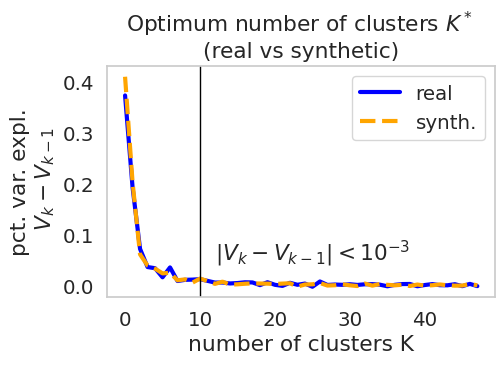

In [44]:
plt.figure(figsize=(5,3))
plt.plot(np.diff(var_expl), lw=3, label="real", color="blue")
plt.plot(np.diff(var_expl_fake), lw=3, label="synth.", 
         color="orange", linestyle="--")
plt.axvline(x=10, color='black')
plt.title("Optimum number of clusters $K^*$ \n(real vs synthetic)")
plt.xlabel("number of clusters K")
plt.ylabel("pct. var. expl.\n $V_k-V_{k-1}$")

plt.legend(loc="best")
plt.text(12, 0.05, "$|V_k-V_{k-1}|<10^{-3}$")

plt.savefig('../figures/nr_clusters_real_fake.png', bbox_inches='tight')


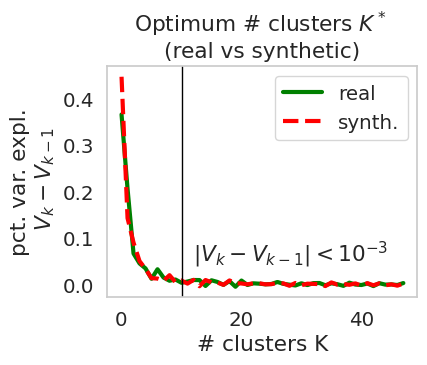

In [48]:
plt.figure(figsize=(4,3))
plt.plot(np.diff(var_expl), lw=3, label="real", color="green")
plt.plot(np.diff(var_expl_fake), lw=3, label="synth.", 
         color="red", linestyle="--")
plt.axvline(x=10, color='black')
plt.title("Optimum # clusters $K^*$ \n(real vs synthetic)")
plt.xlabel("# clusters K")
plt.ylabel("pct. var. expl.\n $V_k-V_{k-1}$")
plt.legend(loc="best")
plt.text(12, 0.05, "$|V_k-V_{k-1}|<10^{-3}$")

plt.savefig('../figures/nr_clusters_real_fake.pdf', 
            format='pdf', dpi=1200, bbox_inches='tight')


In [59]:
K_star = 12
mod_real = KMeans(n_clusters=K_star, n_init=20, max_iter=500)
mod_real.fit(X_real)
centroids_real = mod_real.cluster_centers_
C_real = mod_real.predict(X_real)

In [60]:
K_star = 12
mod_fake = KMeans(n_clusters=K_star, n_init=20, max_iter=500)
mod_fake.fit(X_fake)
centroids_fake = mod_fake.cluster_centers_
C_fake = mod_fake.predict(X_fake)

In [61]:
# Find closest cluster correspondents real <--> fake

from scipy.spatial.distance import cdist

D_fake_real = cdist(centroids_fake, centroids_real)

idx_real2fake = D_fake_real.argmin(0)
idx_fake2real = D_fake_real.argmin(1)

centroids_fake_adj = centroids_fake[idx_real2fake]
C_fake_adj = np.array([idx_real2fake[x] for x in C_fake])

In [62]:
len(np.where(C_real == 0)[0])

36

In [63]:
K = K_star
nx = 3
ny = K / nx
fig, ax = plt.subplots(nx,int(ny), 
                       gridspec_kw={"wspace":0.15, "hspace":0.3},
                       figsize=(15,9), sharex=True, sharey=True)
if len(ax.shape)==1:
    ax = np.expand_dims(ax, axis=0)
for k,a in zip(range(K), ax.flatten()):
    # plot real centroids
    idx = np.where(C_real == k)[0]
    std = X_real[idx,:].std(0)
    q_real = len(idx) / float(len(C_real))
    a.fill_between(distance_km,
       centroids_real[k,:]-std, 
       centroids_real[k,:]+std, 
       color="blue", alpha=0.3)
    a.plot(distance_km, centroids_real[k,:], lw=5, color="blue",
          label="real C%d: %2.1f%%"%(k,100*q_real))
    # plot fake centroids
    idx = np.where(C_fake_adj == k)[0]
    std = X_fake[idx,:].std(0)
    q_fake = len(idx) / float(len(C_fake))
    a.fill_between(distance_km,
       centroids_fake_adj[k,:]-std, 
       centroids_fake_adj[k,:]+std, 
       color="orange", alpha=0.3)
    a.plot(distance_km, centroids_fake_adj[k,:], lw=5, color="orange",
          label="sim. C%d: %2.1f%%"%(k,100*q_fake))
    a.legend(loc="best")
    # a.axis("off")
    if k / ny == nx-1:
        a.set_xlabel("radial distance d")
        a.set_xticks(distance_km[::30])
        a.set_xticklabels(distance_km[::30], rotation=30)
    if k % ny == 0:
        a.set_ylabel("$\hat x_{\cdot}(d)$")
fig.suptitle("Classes of normalized avg. radial profiles $x_{\cdot}(d)$: real vs simulated cities")
fig.subplots_adjust(top=0.92)        
fig.savefig('../figures/profile_classes_centroids_real_fake.png', bbox_inches='tight')


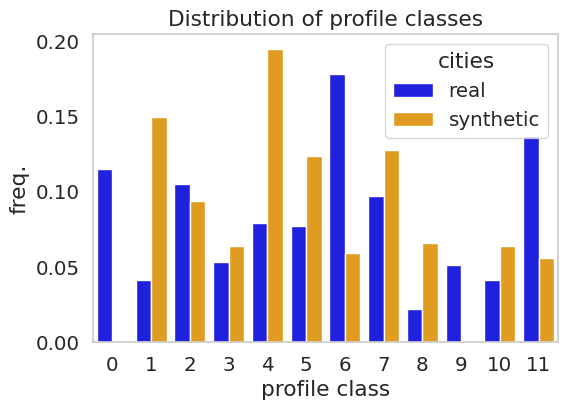

In [51]:
C_df = pd.DataFrame(np.hstack([C_real,C_fake_adj]), 
                    columns=["cluster"])
C_df['cities'] = 'synthetic'
C_df['cities'][:len(C_real)] = 'real'
C_freq = C_df.groupby("cities").apply(lambda x: x['cluster'].value_counts()/float(len(x)))
C_freq = pd.DataFrame(C_freq.reset_index())
C_freq.columns = ["cities", "class", "freq"]

fig, ax = plt.subplots(figsize=(6,4))

sns.barplot(ax=ax, data=C_freq, 
              x="class", y="freq", hue="cities", palette=["blue", "orange"])
ax.set_xlabel("profile class")
ax.set_ylabel("freq.")
ax.set_title("Distribution of profile classes")
fig.savefig('../figures/classes_profiles_distribution_real_vs_fake.png', bbox_inches='tight')

In [413]:
freq_C_real = pd.Series(C_real).value_counts()/float(len(C_real))
freq_C_real = freq_C_real.sort_index()
freq_C_fake = pd.Series(C_fake).value_counts()/float(len(C_fake))
freq_C_fake = freq_C_fake.sort_index()

chisq = chisquare(freq_C_fake, freq_C_real, ddof=0)
chisq.pvalue, chisq.statistic

(0.99999707848600428, 0.57693043901591012)